# Import libraries

In [1]:
import os
import random
import gc

import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.cluster import KMeans

import cv2
from imutils import paths
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.sys.path.append('../src')
from helpers import resize_to_fit

# Load dataset

In [3]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

In [4]:
CAPTCHA_IMAGES_FOLDER = "../data/samples"

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(CAPTCHA_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Grab the labels
    label = image_file.split(os.path.sep)[-1].split('.')[-2]

    # Add the image and it's label to our training data
    data.append(image)
    labels.append(label)

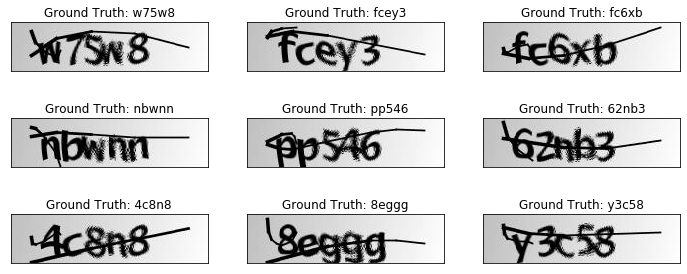

In [5]:
# show sample images
fig = plt.figure(figsize=(12, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(data[i], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

# Pre-processing

## Otsu threshold

In [6]:
data_pre = []
for e in data:
    ret, th = cv2.threshold(e, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(th, kernel, iterations=1)
    erosion = cv2.erode(dilation, kernel, iterations=1)

    data_pre.append(erosion)

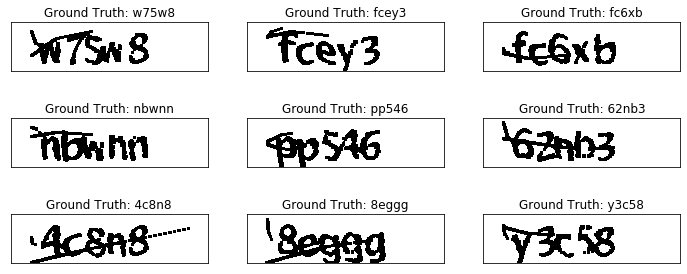

In [7]:
# show sample images
fig = plt.figure(figsize=(12, 5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(data_pre[i], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

# K-Means

In [8]:
#data_pre = data_pre[:100]

In [9]:
data_pts = []
for e in data_pre:
    data_pts.append(np.where(e == 0))
data_pts = np.array(data_pts)
data_pts.shape

(1070, 2)

In [10]:
X = []
thres = 3
for e in data_pts:
    x = (np.vstack((e[1],np.flip(e[0])))).T
    l = []
    # Discard columns with less than thres points
    for i in range(200):
        if len(x[x[:,0] == i]) > thres:
            for f in x[x[:,0] == i]:
                l.append(f)
    x = np.array(l)
    X.append(x)
X = np.array(X)
X.shape

(1070,)

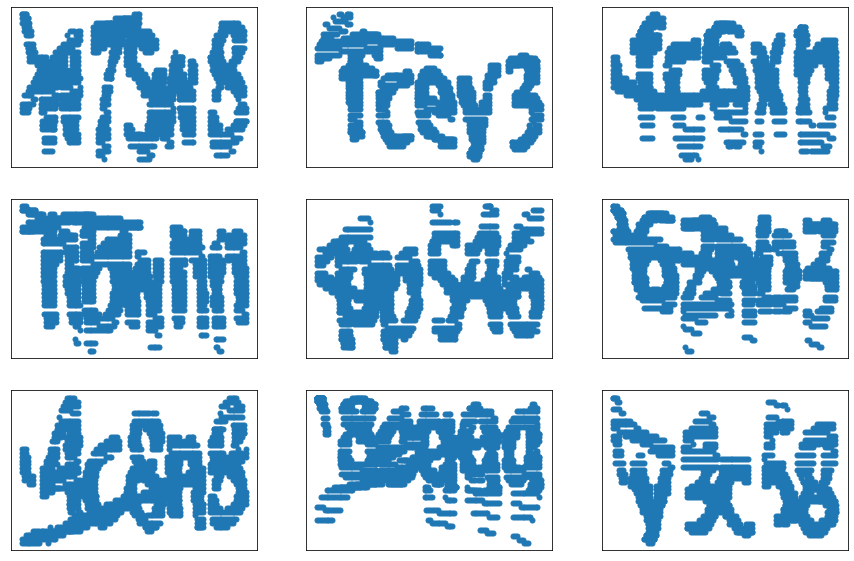

In [11]:
# Show points
fig = plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(X[i][:,0], X[i][:,1], s=100, marker='.')
    plt.xticks([])
    plt.yticks([])

In [12]:
y_kmeans = []
centers_kmeans = []
for i, x in enumerate(X):
    kmeans = KMeans(n_clusters=5)#, init=np.array([(i*200/6.0, 25) for i in range(1,6)]))
    kmeans.fit(x)
    centers_kmeans.append(kmeans.cluster_centers_)
    y_kmeans.append(kmeans.predict(x))

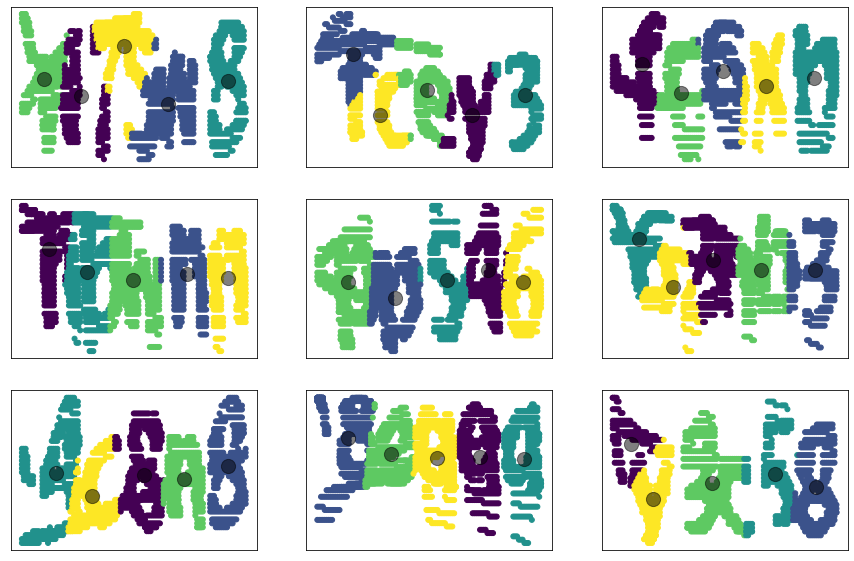

In [13]:
# Show clusters
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(X[i][:, 0], X[i][:, 1], c=y_kmeans[i], s=100, cmap='viridis', marker='.')
    centers = centers_kmeans[i]
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5, marker='o')
    plt.xticks([])
    plt.yticks([])
    currentAxis = plt.gca()
#     for c in centers:
#         currentAxis.add_patch(Rectangle((c - 13, 0), 26, 50, color="red", fill=False))
plt.show()

In [14]:
# Projection in x-axis
X_proj = [x[:,0].reshape(-1,1) for x in X]

In [15]:
# Find clusters in projected data
y_kmeans_proj = []
centers_kmeans_proj = []
for i, x in enumerate(X_proj):
    kmeans = KMeans(n_clusters=5)#, init=np.array([(i*200/6.0, 25) for i in range(1,6)]))
    kmeans.fit(x)
    centers_kmeans_proj.append(kmeans.cluster_centers_)
    y_kmeans_proj.append(kmeans.predict(x))

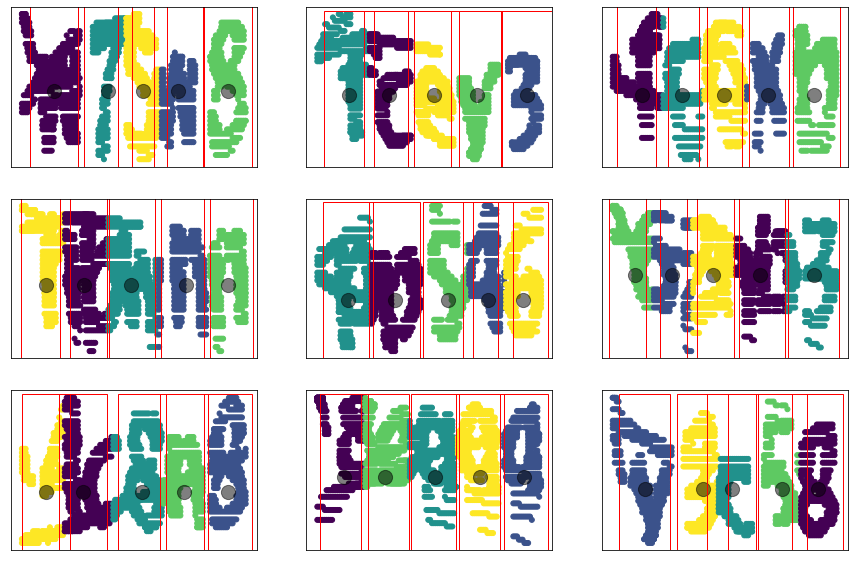

In [16]:
# Show clusters
from matplotlib.patches import Rectangle
fig = plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(X[i][:, 0], X[i][:, 1], c=y_kmeans_proj[i], s=100, cmap='viridis', marker='.')
    centers = centers_kmeans_proj[i]
    plt.scatter(centers, np.ones(centers.shape)*25, c='black', s=200, alpha=0.5, marker='o')
    plt.xticks([])
    plt.yticks([])
    currentAxis = plt.gca()
    for c in centers:
        currentAxis.add_patch(Rectangle((c - 13, 0), 26, 50, color="red", fill=False))
plt.show()

# Crop and save images

In [17]:
centers = [np.sort(e, axis=0) for e in centers_kmeans_proj]

In [18]:
data_chars = []
for i, e in enumerate(data_pre):
    chars = []
    for j in range(5):
        chars.append(e[:,int(centers[i][j]-21):int(centers[i][j]+21)])
    data_chars.append(chars)

In [19]:
letters_dir = os.path.join(data_dir, 'letters/')
letters_dir = '../data/letters'

In [20]:
if not(os.path.isdir(''.join((letters_dir)))):
    os.mkdir(''.join((letters_dir)))

for i,e in enumerate(data_chars):
    for j in range(5):
        if not(os.path.isdir(''.join((letters_dir,'/',labels[i][j],'/')))):
            os.mkdir(''.join((letters_dir,'/',labels[i][j],'/')))
        cv2.imwrite(''.join((letters_dir,'/',labels[i][j],'/',str(i),'.png')),e[j])

## Convolutional Neural Network

In [53]:
LETTER_IMAGES_FOLDER = letters_dir

# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 32, 32)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


In [54]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [73]:
# Split the training data into separate train and test sets
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
le = LabelEncoder().fit(np.stack(list(y_train) + list(y_test)))
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [74]:
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 15
log_interval = 10

In [75]:
X_train_t = (torch.from_numpy(X_train).float().transpose(1,3)).transpose(2,3)
y_train_t = torch.from_numpy(y_train).long()

train_data = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=round(batch_size_train), shuffle=True)

In [76]:
X_test_t = (torch.from_numpy(X_test).float().transpose(1,3)).transpose(2,3)
y_test_t = torch.from_numpy(y_test).long()

test_data = torch.utils.data.TensorDataset(X_test_t, y_test_t)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [77]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

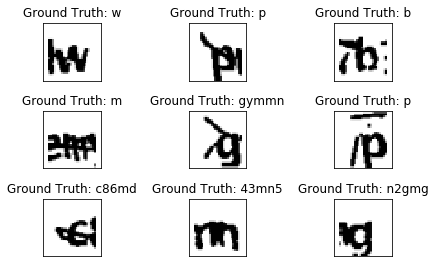

In [78]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(le.inverse_transform(example_targets)[i]))
    plt.xticks([])
    plt.yticks([])

In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 340)
        self.fc2 = nn.Linear(340, 19)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return F.log_softmax(x, dim=0)

In [80]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [81]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [82]:
def train(epoch, v=True):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target, reduction='mean')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if v:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
        torch.save(net.state_dict(), 'model.pth')
        torch.save(optimizer.state_dict(), 'optimizer.pth')

In [83]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [84]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /pytorch/aten/src/THNN/generic/ClassNLLCriterion.c:92

ValueError: x and y must be the same size

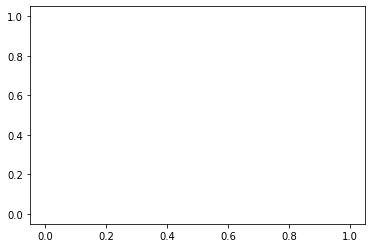

In [85]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

In [ ]:
with torch.no_grad():
    output = net(example_data)

In [ ]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}/{}".format(le.inverse_transform(output.data.max(1, keepdim=True)[1][i])[0],
                                         le.inverse_transform(example_targets[i].view(-1, 1)[0])[0]))
    plt.xticks([])
    plt.yticks([])

http://ceur-ws.org/Vol-1885/93.pdf
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/34843.pdf